## Model Architecture
### 10 epochs

In [1]:
import os
import pathlib
import random

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


import tensorflow as tf
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.utils import Sequence
from keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import (Conv2D,
                                     Flatten,
                                     Activation,
                                     Dense, 
                                     BatchNormalization, 
                                     Dropout,
                                    LeakyReLU)

from keras_vggface.vggface import VGGFace

mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660 Ti, compute capability 7.5


## Read Data 

## Reading Data

In [2]:
BASE_PATH = r'D:\Project\Dataset'
DATA_PATH = os.path.join(BASE_PATH, 'CASIA-SURF-Challenge')

TRAIN_FILE_PATH = "train_list.txt"
TEST_FILE_PATH = "test_private_list.txt"
VAL_FILE_PATH = "val_private_list.txt"
REAL_FILE_PATH = "real_data.txt"
MODEL_PATH = "models"

RESIZE_CROP = (256, 256)

BATCH_SIZE = 32

TRAIN, VAL, TEST = 0.8, 0.1, 0.2


In [3]:
# path = r"C:\Users\hp\Desktop\Project\Dataset\CASIA-SURF-Challenge\Testing"
# test_files = []
# for root, dirs, files in os.walk(path):
#     if files:
#         for file in files:
#             if file.endswith("color.jpg"):
#                 test_files.append(os.path.join(root, file))

                

In [4]:
# path = r"C:\Users\hp\Desktop\Project\Dataset\CASIA-SURF-Challenge\Val"
# for root, dirs, files in os.walk(path):
#     if files:
#         for file in files:
#             if file.endswith("color.jpg"):
#                 test_files.append(os.path.join(root, file))


In [5]:

TRAIN_FILES = os.path.join(DATA_PATH, TRAIN_FILE_PATH)
TEST_FILES = os.path.join(DATA_PATH, TEST_FILE_PATH)
VAL_FILES = os.path.join(DATA_PATH, VAL_FILE_PATH)
REAL_FILES = os.path.join(DATA_PATH, REAL_FILE_PATH)

def read_file(file):
    data_paths = []
    with open(file, 'r') as f:
        while True:
            
            line = f.readline()
            if len(line) == 0:
                break
            line = line.split(" ")[0]
            data_paths.append(line)
            
    return data_paths



train_abs_paths = read_file(TRAIN_FILES)
# real_abs_paths  = read_file(REAL_FILES)
with open(REAL_FILES, "r") as f:
    lines = f.readlines()
    lines = [line[:-1] for line in lines]
# Read Augmented
with open("augmented_image_paths.txt", "r") as f:
    augmented_data_path = f.readlines()
    augmented_data_path = [path[:-1] for path in augmented_data_path]

# Data with not Label
# test_abs_paths = read_file(TEST_FILES)
# val_abs_paths = read_file(VAL_FILES)
# train_abs_paths  = train_abs_paths + augmented_data_path
train_abs_paths = train_abs_paths + lines
train_abs_paths = train_abs_paths + augmented_data_path
print(f"Number of train samples : {len(train_abs_paths)}")


Number of train samples : 40680


In [6]:
def split_fake_real(data):
    data_splited = [path.split('/') for path in data]
    data_splited = ['real_part' in _ for _ in data_splited]
    real_index = data_splited.index(True)
    labels = [0] * real_index + [1] * (len(data) - real_index)
    return labels

In [7]:
def read_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype='float32')
    image = tf.image.resize(image, size=RESIZE_CROP)
    return image

In [8]:
train_Y = split_fake_real(train_abs_paths)
train_X = [os.path.join(DATA_PATH, image_path) for image_path in train_abs_paths]
real_number = sum(train_Y)
real_percentage = sum(train_Y)*100 / len(train_Y)

fake_number = len(train_Y) - real_number
fake_percentage = 100 - real_percentage
print(f"Number of Real images : {real_number}")
print(f"Percentage of Real images : %{real_percentage:.2f}")
print("-----------------------------------")
print(f"Number of Fake images : {fake_number}")
print(f"Percentage of Fake images : %{fake_percentage:.2f}")

Number of Real images : 20356
Percentage of Real images : %50.04
-----------------------------------
Number of Fake images : 20324
Percentage of Fake images : %49.96


In [9]:
# Define augmentation functions
def random_flip(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def random_brightness(image, label):
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

def random_contrast(image, label):
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

def random_rotate_small(image, label, max_angle=15):
    angle = tf.random.uniform(shape=[], minval=-max_angle, maxval=max_angle, dtype=tf.float32)
    image = tf.image.rot90(image, tf.cast(angle / 90, tf.int32))
    return image, label

# Define augmentation pipeline for label 1 (fake images)
def apply_augmentation(image, label):
    if label == 1:
        image, label = random_flip(image, label)
        image, label = random_brightness(image, label)
        image, label = random_contrast(image, label)
        image, label = random_rotate_small(image, label)
    return image, label

### Apply augmentation on Real Data


In [10]:
# with open("augmented_image_paths.txt", 'r') as f:
#     data = f.readlines()

# with open("augmented_image_paths.txt", 'w') as f:
#     for path in data:
#         f.write(path.replace("C:\\Users\\hp\\Desktop\\Project\\Dataset\\CASIA-SURF-Challenge\\", ""))

In [11]:

# # Assuming you have already defined the augmentation functions as before...

# # List of file paths to your train images (without the common prefix)
# real_image_paths = train_X[20324:]

# # Function to read and augment an image from the file path
# def read_and_augment_image(image_path):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(image, channels=3)  # You can also use decode_png() if images are in PNG format
#     image, _ = apply_augmentation(image, label=1)  # Assuming label=1 for real images
#     return image

# # Function to save the augmented image back to the same file path with "augmented" in the name
# def save_augmented_image(image, image_path):
#     base_dir = os.path.dirname(image_path)
#     base_name = os.path.basename(image_path)
#     augmented_base_name = "augmented_" + base_name
#     augmented_image_path = os.path.join(base_dir, augmented_base_name)
    
#     if os.path.exists(augmented_image_path):
#         print(f"Augmented version of {image_path} already exists. Skipping...")
#         return augmented_image_path
    
#     encoded_image = tf.image.encode_jpeg(tf.cast(image, tf.uint8))  # You can use encode_png() for PNG format
#     tf.io.write_file(augmented_image_path, encoded_image)

#     return augmented_image_path

# # Create a list to store the paths of all augmented images
# augmented_image_paths = []

# # Loop over each real image path, read, augment, and save back with "augmented" in the name
# for real_image_path in real_image_paths:
#     augmented_image = read_and_augment_image(real_image_path)
#     augmented_image_path = save_augmented_image(augmented_image, real_image_path)
#     augmented_image_paths.append(augmented_image_path)

# # Remove the common prefix from each path
# common_prefix = "C:Users/hp/Desktop/Project/Dataset/CASIA-SURF-Challenge/"
# augmented_image_paths_relative = [path.replace(common_prefix, "") for path in augmented_image_paths]

# # Save the paths of augmented images to the txt file without the common prefix
# txt_file_path = "augmented_image_paths.txt"
# with open(txt_file_path, 'w') as file:
#     for path in augmented_image_paths_relative:
#         file.write(path + '\n')

# print("Augmentation and save completed.")


In [12]:
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y, test_size=TEST, shuffle=True)
# # The validation and test data is not labeled so we use train part
# test_x_path = [os.path.join(DATA_PATH, image_path) for image_path in test_abs_paths]
# val_x_path = [os.path.join(DATA_PATH, image_path) for image_path in val_abs_paths]
print(f"Number train data : {len(train_x)}")
print(f"Number test data : {len(test_x)}")

Number train data : 32544
Number test data : 8136


In [13]:
with open("testx_5.txt", "w") as f:
    for path in test_x:
        f.write(path + "\n")
        
with open("testy_5.txt", "w") as f:
    for path in test_y:
        f.write(str(path) + "\n")

In [14]:
print(f"Real data in train : {sum(train_y)}")
print(f"Fake data in train : {len(train_y) - sum(train_y)}")

Real data in train : 16305
Fake data in train : 16239


#### Ploting some of train images


Images size : (256, 256, 3)


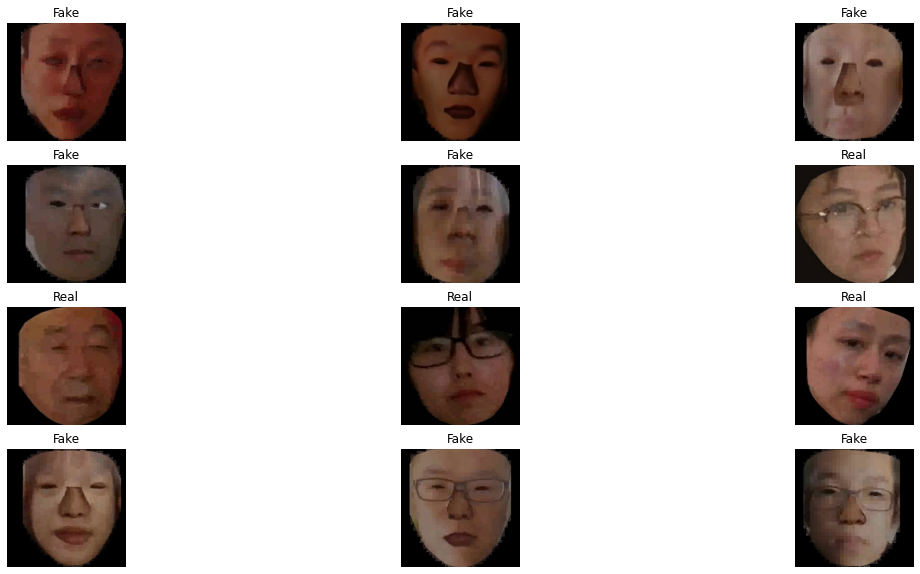

In [15]:
num_image = 12
rows = 4
column = 3

figs, axes = plt.subplots(rows, column, figsize=(20, 10))

axes = axes.ravel()

for i in range(num_image):
    img = random.choice(train_x)
    label = train_y[train_x.index(img)]
    img = read_image(img)
    label = "Real" if label else "Fake"
    axes[i].imshow(img)
    axes[i].set_title(label, fontsize=12)
    axes[i].axis("off")
print(f"Images size : {img.shape}")

plt.show()

## 

In [16]:
# Used this
def generator(images, labels):
    idx = np.arange(len(images))
    for i in idx:
        yield (read_image(images[i]), labels[i])

In [17]:


test_dataset = tf.data.Dataset.from_generator(
            lambda : generator(test_x, test_y),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

## Model Architecture

In [18]:
performance_scores = []

# Define the number of folds (k)
K = 5

# Initialize the k-fold cross-validator
kf = KFold(n_splits=K, shuffle=True, random_state=42)
folds = kf.split(train_x, train_y)

# Model Architecture
IMG_SIZE = (256, 256)

IMG_SHAPE = IMG_SIZE + (3,)


In [19]:
performance_scores = []

### Model 1


In [20]:
# FOLD 1
train_index, val_index = next(folds)
print(train_index[:10])
print(val_index[:10])

[ 0  1  2  3  4  5  7  9 10 11]
[ 6  8 30 33 34 35 43 46 52 70]


In [21]:
X_train, X_val = [train_x[i] for i in train_index], [train_x[i] for i in val_index]
y_train, y_val = [train_y[i] for i in train_index], [train_y[i] for i in val_index]
train_dataset_1 = tf.data.Dataset.from_generator(
            lambda : generator(X_train, y_train),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

val_dataset_1 =  tf.data.Dataset.from_generator(
            lambda : generator(X_val, y_val),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

In [22]:

base_model_1 = VGGFace(input_shape=IMG_SHAPE, include_top=False, model='vgg16')
print(f"Number of layers in VGGFACE : {len(base_model_1.layers)}")

len(base_model_1.layers)
base_model_1.trainable = False

fine_tune_from_layer = 16
for layer in base_model_1.layers[-3:]:
    layer.trainable = True


model_1 = Sequential()
model_1.add(base_model_1)
model_1.add(Flatten())

model_1.add(Dense(1024, activation='relu'))  # Fully connected layer
model_1.add(BatchNormalization())
model_1.add(Dropout(0.3))

model_1.add(Dense(512, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_1.add(BatchNormalization())
model_1.add(Dropout(0.5))

model_1.add(Dense(256, activation='relu'))  # Fully connected layer
model_1.add(BatchNormalization())
model_1.add(Dropout(0.2))

model_1.add(Dense(128, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_1.add(BatchNormalization())


model_1.add(Dense(1, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])

base_model_1.summary()

Number of layers in VGGFACE : 19
Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 256, 256, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 256, 256, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 128, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 128, 128, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)

In [24]:
# metrics_callback_1 = MetricsCallback(val_dataset_1.batch(BATCH_SIZE).prefetch(3))
early_stopping_1 = EarlyStopping(patience=5, restore_best_weights=True)

history_1 = model_1.fit(train_dataset_1.batch(BATCH_SIZE).prefetch(3).repeat(),
                    steps_per_epoch=int(len(X_train) // BATCH_SIZE),
                    epochs=10,
                    verbose=1,
                    validation_data=val_dataset_1.batch(BATCH_SIZE).prefetch(3).repeat(),
                    validation_steps=int(len(X_val) // BATCH_SIZE),
                    use_multiprocessing=True,
                    callbacks=[early_stopping_1]
                    )

Epoch 1/10
813/813 [==============================] - 291s 344ms/step - loss: 0.0370 - accuracy: 0.9875 - val_loss: 0.0019 - val_accuracy: 0.9998
Epoch 2/10
813/813 [==============================] - 285s 345ms/step - loss: 0.0100 - accuracy: 0.9971 - val_loss: 0.0011 - val_accuracy: 0.9998
Epoch 3/10
813/813 [==============================] - 288s 354ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.0012 - val_accuracy: 0.9995
Epoch 4/10
813/813 [==============================] - 295s 363ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 5.4707e-04 - val_accuracy: 0.9998
Epoch 5/10
813/813 [==============================] - 291s 359ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 6/10
813/813 [==============================] - 290s 357ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 6.7962e-04 - val_accuracy: 0.9997
Epoch 7/10
813/813 [==============================] - 296s 364ms/step - loss: 0.0032 - accuracy: 0.9988 - val_loss: 

In [25]:
loss_1, accuracy_1 = model_1.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))
performance_scores.append(accuracy_1)

255/255 [==============================] - 66s 260ms/step - loss: 0.0010 - accuracy: 0.9996


In [26]:
model_1.save("models/model_1_casia_vgg_train")
model_1.save_weights("models/model_1_casia_vgg_train")

INFO:tensorflow:Assets written to: models/model_1_casia_vgg_train\assets


INFO:tensorflow:Assets written to: models/model_1_casia_vgg_train\assets


### Model 2


In [27]:
# FOLD 2
train_index, val_index = next(folds)
print(train_index[:10])
print(val_index[:10])

[ 0  1  2  5  6  8  9 10 11 12]
[ 3  4  7 17 23 29 31 41 42 44]


In [28]:
X_train, X_val = [train_x[i] for i in train_index], [train_x[i] for i in val_index]
y_train, y_val = [train_y[i] for i in train_index], [train_y[i] for i in val_index]
train_dataset_2 = tf.data.Dataset.from_generator(
            lambda : generator(X_train, y_train),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

val_dataset_2 =  tf.data.Dataset.from_generator(
            lambda : generator(X_val, y_val),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

In [31]:

base_model_2 = VGGFace(input_shape=IMG_SHAPE, include_top=False, model='vgg16')
print(f"Number of layers in VGGFACE : {len(base_model_2.layers)}")

len(base_model_2.layers)
base_model_2.trainable = False

fine_tune_from_layer = 16
for layer in base_model_2.layers[-3:]:
    layer.trainable = True


model_2 = Sequential()
model_2.add(base_model_2)
model_2.add(Flatten())
model_2.add(Dense(1024, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))

model_2.add(Dense(512, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))

model_2.add(Dense(256, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))

model_2.add(Dense(128, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_2.add(BatchNormalization())


model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])



Number of layers in VGGFACE : 19


In [32]:
# metrics_callback_1 = MetricsCallback(val_dataset_1.batch(BATCH_SIZE).prefetch(3))
early_stopping_2 = EarlyStopping(patience=5, restore_best_weights=True)

history_2 = model_2.fit(train_dataset_2.batch(BATCH_SIZE).prefetch(3).repeat(),
                    steps_per_epoch=int(len(X_train) // BATCH_SIZE),
                    epochs=10,
                    verbose=1,
                    validation_data=val_dataset_2.batch(BATCH_SIZE).prefetch(3).repeat(),
                    validation_steps=int(len(X_val) // BATCH_SIZE),
                    use_multiprocessing=True,
                    callbacks=[early_stopping_2]
                    )

Epoch 1/10
813/813 [==============================] - 284s 346ms/step - loss: 0.0276 - accuracy: 0.9905 - val_loss: 0.0093 - val_accuracy: 0.9972
Epoch 2/10
813/813 [==============================] - 293s 360ms/step - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.0013 - val_accuracy: 0.9997
Epoch 3/10
813/813 [==============================] - 291s 358ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 4.1583e-04 - val_accuracy: 0.9998
Epoch 4/10
813/813 [==============================] - 291s 358ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0012 - val_accuracy: 0.9998
Epoch 5/10
813/813 [==============================] - 286s 352ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 7.4830e-04 - val_accuracy: 0.9998
Epoch 6/10
813/813 [==============================] - 286s 352ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 4.7726e-04 - val_accuracy: 0.9998
Epoch 7/10
813/813 [==============================] - 286s 351ms/step - loss: 0.0018 - accuracy: 0.9993 - val_lo

In [ ]:
loss_2, accuracy_2 = model_2.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))
performance_scores.append(accuracy_2)

In [ ]:
model_2.save("models/model_2_casia_vgg_train")
model_2.save_weights("models/model_2_casia_vgg_train")

### Model 3


In [37]:
train_index, val_index = next(folds)
print(train_index[:10])
print(val_index[:10])

[ 1  2  3  4  6  7  8  9 10 11]
[ 0  5 14 15 19 20 22 26 27 38]


In [38]:
# FOLD 2

X_train, X_val = [train_x[i] for i in train_index], [train_x[i] for i in val_index]
y_train, y_val = [train_y[i] for i in train_index], [train_y[i] for i in val_index]
train_dataset_3 = tf.data.Dataset.from_generator(
            lambda : generator(X_train, y_train),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

val_dataset_3 =  tf.data.Dataset.from_generator(
            lambda : generator(X_val, y_val),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)



In [39]:
base_model_3 = VGGFace(input_shape=IMG_SHAPE, include_top=False, model='vgg16')
print(f"Number of layers in VGGFACE : {len(base_model_3.layers)}")

base_model_3.trainable = False

# fine_tune_from_layer = 16
# for layer in base_model_3.layers[-40:]:
#     layer.trainable = True


model_3 = Sequential()
model_3.add(base_model_3)
model_3.add(Flatten())
model_3.add(Dense(1024, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))

model_3.add(Dense(512, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))

model_3.add(Dense(256, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))

model_3.add(Dense(128, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_3.add(BatchNormalization())


model_3.add(Dense(1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])



Number of layers in VGGFACE : 19


In [40]:
# metrics_callback_1 = MetricsCallback(val_dataset_1.batch(BATCH_SIZE).prefetch(3))
early_stopping_3 = EarlyStopping(patience=5, restore_best_weights=True)

history_3 = model_3.fit(train_dataset_3.batch(BATCH_SIZE).prefetch(3).repeat(),
                    steps_per_epoch=int(len(X_train) // BATCH_SIZE),
                    epochs=10,
                    verbose=1,
                    validation_data=val_dataset_3.batch(BATCH_SIZE).prefetch(3).repeat(),
                    validation_steps=int(len(X_val) // BATCH_SIZE),
                    use_multiprocessing=True,
                    callbacks=[early_stopping_3]
                    )

Epoch 1/10
813/813 [==============================] - 323s 394ms/step - loss: 0.0273 - accuracy: 0.9912 - val_loss: 0.0048 - val_accuracy: 0.9988
Epoch 2/10
813/813 [==============================] - 325s 401ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.0016 - val_accuracy: 0.9992
Epoch 3/10
813/813 [==============================] - 319s 392ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0013 - val_accuracy: 0.9995
Epoch 4/10
813/813 [==============================] - 324s 398ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 9.9838e-04 - val_accuracy: 0.9995
Epoch 5/10
813/813 [==============================] - 324s 399ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0013 - val_accuracy: 0.9995
Epoch 6/10
813/813 [==============================] - 325s 400ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 5.8323e-04 - val_accuracy: 0.9995
Epoch 7/10
813/813 [==============================] - 324s 398ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 

In [41]:
loss_3, accuracy_3 = model_3.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))
performance_scores.append(accuracy_3)

255/255 [==============================] - 203s 793ms/step - loss: 0.0045 - accuracy: 0.9988


In [42]:
model_3.save("models/model_3_casia_vgg_no_train")
model_3.save_weights("models/model_3_casia_vgg_no_train")

INFO:tensorflow:Assets written to: models/model_3_casia_vgg_no_train\assets


INFO:tensorflow:Assets written to: models/model_3_casia_vgg_no_train\assets


### Model 4

In [43]:
# FOLD 2
train_index, val_index = next(folds)
print(train_index[:10])
print(val_index[:10])

[ 0  3  4  5  6  7  8  9 11 13]
[ 1  2 10 12 18 21 28 32 36 37]


In [44]:
# FOLD 2

X_train, X_val = [train_x[i] for i in train_index], [train_x[i] for i in val_index]
y_train, y_val = [train_y[i] for i in train_index], [train_y[i] for i in val_index]
train_dataset_4 = tf.data.Dataset.from_generator(
            lambda : generator(X_train, y_train),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

val_dataset_4 =  tf.data.Dataset.from_generator(
            lambda : generator(X_val, y_val),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

base_model_4 = VGGFace(input_shape=IMG_SHAPE, include_top=False, model='vgg16')
print(f"Number of layers in VGGFACE : {len(base_model_4.layers)}")

base_model_4.trainable = False

# fine_tune_from_layer = 16
# for layer in base_model_4.layers[-40:]:
#     layer.trainable = True


model_4 = Sequential()
model_4.add(base_model_4)
model_4.add(Flatten())
model_4.add(Dense(1024, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_4.add(BatchNormalization())
model_4.add(Dropout(0.2))

model_4.add(Dense(512, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_4.add(BatchNormalization())
model_4.add(Dropout(0.2))

model_4.add(Dense(256, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_4.add(BatchNormalization())
model_4.add(Dropout(0.2))

model_4.add(Dense(128, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_4.add(BatchNormalization())


model_4.add(Dense(1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])



Number of layers in VGGFACE : 19


In [45]:
# metrics_callback_1 = MetricsCallback(val_dataset_1.batch(BATCH_SIZE).prefetch(3))
early_stopping_4 = EarlyStopping(patience=5, restore_best_weights=True)

history_4 = model_4.fit(train_dataset_4.batch(BATCH_SIZE).prefetch(3).repeat(),
                    steps_per_epoch=int(len(X_train) // BATCH_SIZE),
                    epochs=10,
                    verbose=1,
                    validation_data=val_dataset_4.batch(BATCH_SIZE).prefetch(3).repeat(),
                    validation_steps=int(len(X_val) // BATCH_SIZE),
                    use_multiprocessing=True,
                    callbacks=[early_stopping_4]
                    )

Epoch 1/10
813/813 [==============================] - 506s 620ms/step - loss: 0.0279 - accuracy: 0.9912 - val_loss: 0.0072 - val_accuracy: 0.9985
Epoch 2/10
813/813 [==============================] - 321s 396ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0024 - val_accuracy: 0.9992
Epoch 3/10
813/813 [==============================] - 317s 390ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0025 - val_accuracy: 0.9994
Epoch 4/10
813/813 [==============================] - 317s 391ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9995
Epoch 5/10
813/813 [==============================] - 317s 390ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 6/10
813/813 [==============================] - 317s 390ms/step - loss: 9.7035e-04 - accuracy: 0.9997 - val_loss: 0.0183 - val_accuracy: 0.9957
Epoch 7/10
813/813 [==============================] - 318s 391ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.00

In [46]:
loss_4, accuracy_4 = model_4.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))
performance_scores.append(accuracy_4)

255/255 [==============================] - 85s 333ms/step - loss: 0.0039 - accuracy: 0.9993


In [47]:
model_4.save("models/model_4_casia_vgg_no_train")
model_4.save_weights("models/model_4_casia_vgg_no_train")

INFO:tensorflow:Assets written to: models/model_4_casia_vgg_no_train\assets


INFO:tensorflow:Assets written to: models/model_4_casia_vgg_no_train\assets


### Model 5

In [48]:
# FOLD 2
train_index, val_index = next(folds)
print(train_index[:10])
print(val_index[:10])

X_train, X_val = [train_x[i] for i in train_index], [train_x[i] for i in val_index]
y_train, y_val = [train_y[i] for i in train_index], [train_y[i] for i in val_index]
train_dataset_5 = tf.data.Dataset.from_generator(
            lambda : generator(X_train, y_train),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

val_dataset_5 =  tf.data.Dataset.from_generator(
            lambda : generator(X_val, y_val),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

base_model_5 = VGGFace(input_shape=IMG_SHAPE, include_top=False, model='vgg16')
print(f"Number of layers in VGGFACE : {len(base_model_5.layers)}")

base_model_5.trainable = False

# fine_tune_from_layer = 16
# for layer in base_model_5.layers[-40:]:
#     layer.trainable = True

model_5 = Sequential()
model_5.add(base_model_5)
model_5.add(Flatten())
model_5.add(Dense(1024, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_5.add(BatchNormalization())
model_5.add(Dropout(0.2))

model_5.add(Dense(512, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_5.add(BatchNormalization())
model_5.add(Dropout(0.2))

model_5.add(Dense(256, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_5.add(BatchNormalization())
model_5.add(Dropout(0.2))

model_5.add(Dense(128, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_5.add(BatchNormalization())


model_5.add(Dense(1, activation='sigmoid'))
model_5.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])



[ 0  1  2  3  4  5  6  7  8 10]
[ 9 11 13 16 24 25 40 53 55 60]
Number of layers in VGGFACE : 19


In [49]:
# metrics_callback_1 = MetricsCallback(val_dataset_1.batch(BATCH_SIZE).prefetch(3))
early_stopping_5 = EarlyStopping(patience=5, restore_best_weights=True)

history_5 = model_5.fit(train_dataset_5.batch(BATCH_SIZE).prefetch(3).repeat(),
                    steps_per_epoch=int(len(X_train) // BATCH_SIZE),
                    epochs=10,
                    verbose=1,
                    validation_data=val_dataset_5.batch(BATCH_SIZE).prefetch(3).repeat(),
                    validation_steps=int(len(X_val) // BATCH_SIZE),
                    use_multiprocessing=True,
                    callbacks=[early_stopping_5]
                    )

Epoch 1/10
813/813 [==============================] - 316s 385ms/step - loss: 0.0293 - accuracy: 0.9904 - val_loss: 0.0027 - val_accuracy: 0.9988
Epoch 2/10
813/813 [==============================] - 328s 399ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0025 - val_accuracy: 0.9994
Epoch 3/10
813/813 [==============================] - 322s 396ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0060 - val_accuracy: 0.9986
Epoch 4/10
813/813 [==============================] - 321s 395ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 5/10
813/813 [==============================] - 327s 402ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0027 - val_accuracy: 0.9997
Epoch 6/10
813/813 [==============================] - 326s 402ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 7/10
813/813 [==============================] - 324s 398ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0022 -

In [50]:
loss_5, accuracy_5 = model_5.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))
performance_scores.append(accuracy_5)

255/255 [==============================] - 73s 285ms/step - loss: 0.0014 - accuracy: 0.9996


In [51]:
model_5.save("models/model_5_casia_vgg_no_train")
model_5.save_weights("models/model_5_casia_vgg_no_train")

INFO:tensorflow:Assets written to: models/model_5_casia_vgg_no_train\assets


INFO:tensorflow:Assets written to: models/model_5_casia_vgg_no_train\assets


{}

## Training

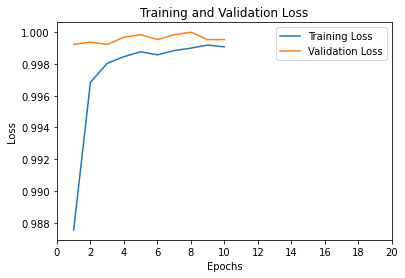

In [70]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange

# Load the training and validation loss dictionaries
train_values = history_1.history['accuracy']
val_values = history_1.history['val_accuracy']

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 11)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

## Testing


In [28]:
image = [read_image(im) for im in train_x[20:40]]
image[0].shape

TensorShape([256, 256, 3])

In [29]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))

# Predict on the test dataset
predictions = model.predict(test_dataset.batch(BATCH_SIZE).prefetch(3))
predicted_labels = np.round(predictions).flatten()

# Get the true labels for the test dataset
true_labels = np.array([label.numpy().item() for _, label in test_dataset])

# Calculate metrics on the test dataset
test_f1 = f1_score(true_labels, predicted_labels)
test_precision = precision_score(true_labels, predicted_labels)
test_recall = recall_score(true_labels, predicted_labels)

# Print the metrics
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


115/115 [==============================] - 23s 197ms/step - loss: 0.0415 - accuracy: 0.9872
Test Accuracy: 0.9871655106544495
Test F1 Score: 0.9874163319946452
Test Precision: 0.9792883696229421
Test Recall: 0.9956803455723542


In [69]:

# Function to display the image and labels
def display_image_with_labels(image, real_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Real Label: {real_label}, Predicted Label: {predicted_label:.2f}")
    plt.show()

def display_model(model, test_dataset):
    # Predict on the validation dataset
    predictions = model.predict(test_dataset.batch(BATCH_SIZE).prefetch(3))
    predicted_labels = np.round(predictions).flatten()

    # # Loop over each image, real label, and predicted label
    for i, (image, real_label) in enumerate(test_dataset.take(len(predicted_labels))):
        predicted_label = predicted_labels[i]

        # Convert the image tensor to a NumPy array for display
        image_np = image.numpy()

        # Convert real_label to a scalar value (assuming it's a single-element tensor)
        real_label = real_label.numpy().item()

        # Display the image with the real label and predicted label
        display_image_with_labels(image_np, real_label, predicted_label)


In [71]:
def get_dataset():
    test_dataset = tf.data.Dataset.from_generator(
            lambda : generator(test_x, test_y),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
    )
    return test_dataset

In [52]:
# test = get_dataset()
# display_model(model_1, test)

In [51]:
# test = get_dataset()
# display_model(model_2, test)

In [ ]:
test = get_dataset()
display_model(model_3, test)

In [ ]:
test = get_dataset()
display_model(model_4, test)

In [ ]:
test = get_dataset()
display_model(model_5, test)

In [53]:
all_loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5
all_acc = accuracy_1 + accuracy_2 + accuracy_3 + accuracy_4 + accuracy_5
print(f"Average loss : {all_loss / 5}")
print(f"Average Accuracy : {all_acc / 5}")

Average loss : 0.14069488134700806
Average Accuracy : 0.9011799454689026


In [54]:
max([accuracy_1 ,accuracy_2 ,accuracy_3 ,accuracy_4, accuracy_5])

0.9997541904449463

In [55]:
a = [accuracy_1 ,accuracy_2 ,accuracy_3 ,accuracy_4, accuracy_5]

In [56]:
a

[0.9997541904449463,
 0.5084808468818665,
 0.9987708926200867,
 0.9992625117301941,
 0.9996312856674194]

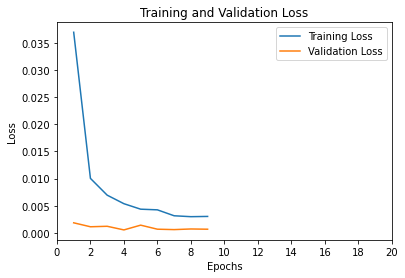

In [35]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange

# Load the training and validation loss dictionaries
train_values = history_1.history['loss']
val_values = history_1.history['val_loss']

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 10)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

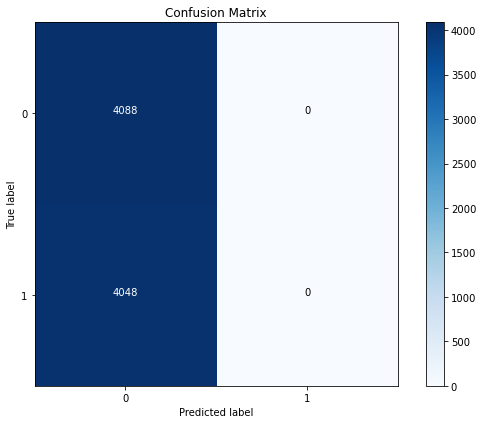

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools

predictions = model_1.predict(test_dataset.batch(BATCH_SIZE).prefetch(3))
predicted_labels = np.round(predictions).flatten() 


cm = confusion_matrix(predicted_labels, np.argmax(predictions, axis=1))

class_labels = [0, 1]

# Plot confusion matrix as a heatmap using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the axes
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Display values in the cells
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
